## Image Compression Using Singular Value Decomposition

In [176]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn import datasets as ds
from PIL import Image

from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

However, SVD gives the best approximation (in terms of Frobenius norm)

In [180]:
# compute SVD for the matrix
U, S, V = np.linalg.svd(X)

Computing an approximation of the image using the first column of U and first row of V reproduces the most prominent feature of the image, the light area on top and the dark area on the bottom. The darkness of the arch causes the extra darkness in the middle of the reconstruction. 

SVD error is 51286.96


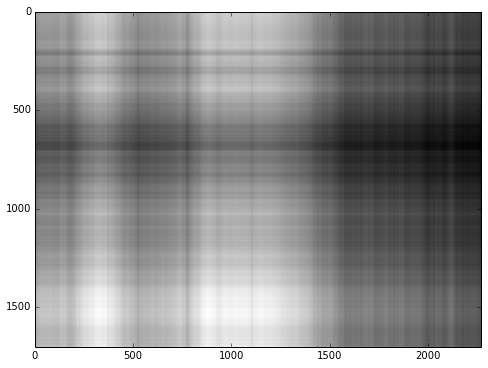

In [181]:
Xhat = np.matrix(U[:, :1]) * np.diag(S[:1]) * np.matrix(V[:1, :])
plt.figure(figsize=(9,6))
plt.imshow(Xhat, cmap='gray');
print('SVD error is %.2f')%np.linalg.norm(X - Xhat,ord='fro')


This is the best rank-1 approximation that you can get (for Frobenius norm).
Now compute the reconstruction for higher rank approximations.

Observe below that using 50 singular vectors we can reasonably approximate the image. The data needed for the rank 50 approximation is (1704 x 50) + 50 + (50 x 2272) = 198850 instead of the original 3871488 pixels. This is just 5% of the original data!

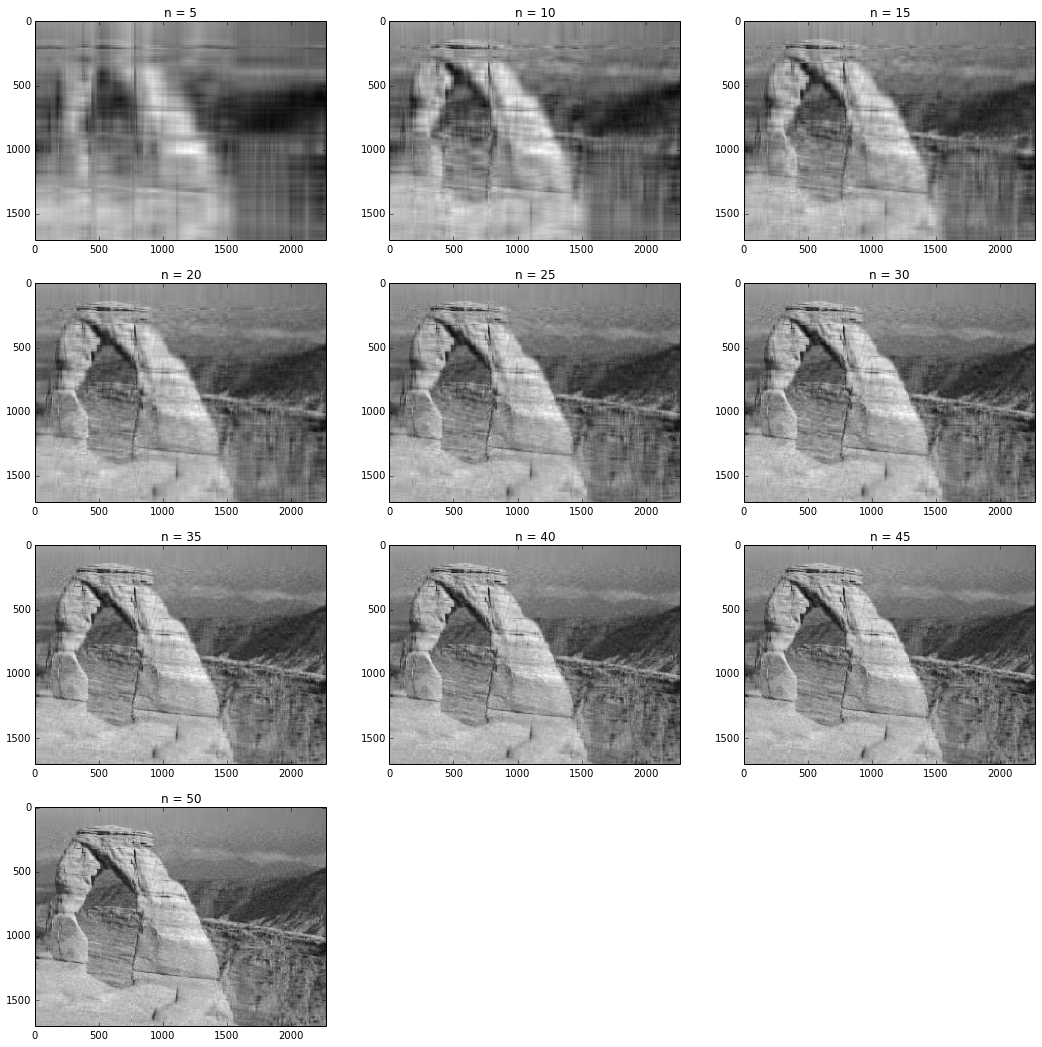

In [186]:
fig = plt.figure(1,figsize=[18,18],dpi=300)
c = 1
errs = []
for i in xrange(5, 51, 5):
    Xhat = np.matrix(U[:, :i]) * np.diag(S[:i]) * np.matrix(V[:i, :])
    plt.subplot(4,3,c)
    c = c + 1
    plt.imshow(Xhat, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    errs.append(np.linalg.norm(X - Xhat,ord='fro'))

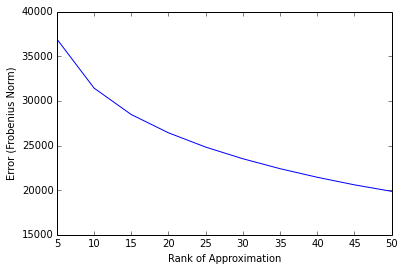

In [195]:
# plot error
plt.plot(xrange(5, 51, 5),errs)
plt.xlabel('Rank of Approximation')
plt.ylabel('Error (Frobenius Norm)')

### Spectral Clustering Illustration

(-1.2254645299595175,
 1.2393764851127851,
 -1.1896347225493169,
 1.1793091356763761)

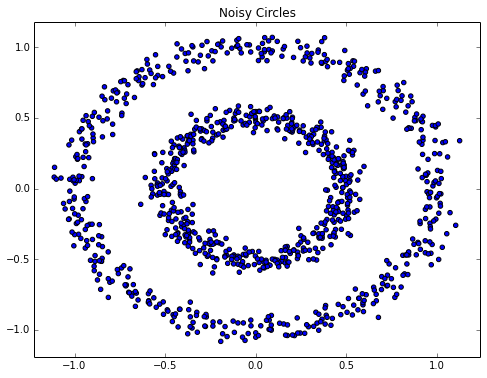

In [166]:
# generate data
X,c = ds.make_circles(n_samples=1000, factor=.5,noise=.05)
# plot
fig = plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1])
plt.title("Noisy Circles")
plt.axis('tight')

We first show how kMeans clustering is not suitable for such kind of data

In [156]:
# perform k means clustering on this data
kmeans = cluster.KMeans(init='k-means++', n_clusters=2)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

(-1.1865752395608886,
 1.1794249221142756,
 -1.2472864412359059,
 1.2142168009515406)

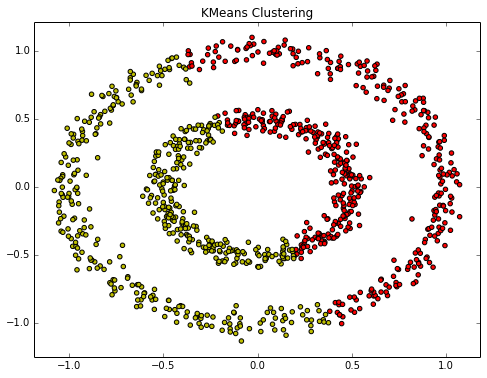

In [152]:
c = kmeans.labels_
# plot with cluster assignments
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[np.where(c == 0), 0], X[np.where(c == 0), 1],c= 'r')
ax.scatter(X[np.where(c == 1), 0], X[np.where(c == 1), 1],c= 'y')
ax.set_title("KMeans Clustering")
plt.axis('tight')

Now let us try Spectral Clustering

In [157]:
spectral = cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack',affinity="nearest_neighbors")
spectral.fit(X)

SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver='arpack', eigen_tol=0.0,
          gamma=1.0, kernel_params=None, n_clusters=2, n_init=10,
          n_neighbors=10, random_state=None)

(-1.1857284653673403,
 1.1793845995336305,
 -1.2444638605907445,
 1.21408239234939)

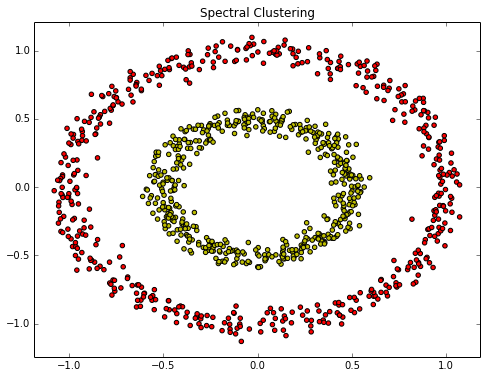

In [158]:
c = spectral.labels_
# plot with cluster assignments
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[np.where(c == 0), 0], X[np.where(c == 0), 1],c= 'r')
ax.scatter(X[np.where(c == 1), 0], X[np.where(c == 1), 1],c= 'y')
ax.set_title("Spectral Clustering")
plt.axis('tight')

## Comparing different clustering algorithms on toy datasets 
Adapted from the sklearn page on clustering
http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

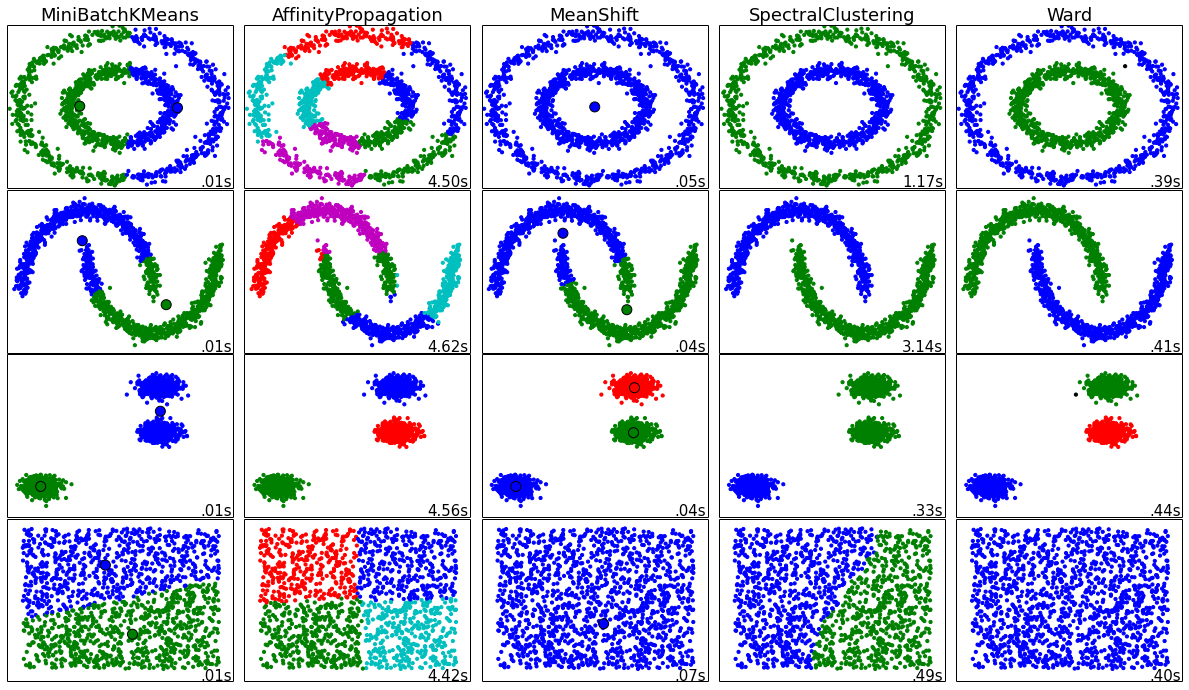

In [173]:
import sklearn
np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = sklearn.datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons = sklearn.datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = sklearn.datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward',
    'DBSCAN', 'Birch']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

ds = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(ds):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=2)    
    spectral = cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack',affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,preference=-200)

    clustering_algorithms = [two_means, affinity_propagation, ms, spectral,dbscan]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
